In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import copy
from collections import namedtuple
from functools import partial
import matplotlib.pyplot as plt
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

# This notebook will look at the convergence rate for different kinds of graphs
\*Even though gibbs isn't the best choice for getting a good marginal value, will include the plot of the marginal values that are sampled anyway

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.GM.Models.DiscreteGraphModels import *
from GenModels.GM.States.GraphicalMessagePassing import *

In [3]:
graphs = []
for _ in range( 50 ):
    line = DataGraph()
    for i in range( 1, 30 ):
        line.addEdge( parents=[ i-1 ], children=[ i ] )
    graphs.append( ( line, np.array( [] ) ) )

In [54]:
graphs = [ ( graph1(), np.array( [] ) ),
           ( graph2(), np.array( [] ) ),
           ( graph3(), np.array( [] ) ),
           ( graph4(), np.array( [] ) ),
           ( graph5(), np.array( [] ) ),
           ( graph6(), np.array( [] ) ),
           ( graph7(), np.array( [] ) ),
           cycleGraph1(),
           cycleGraph2(),
           cycleGraph3(),
           cycleGraph7(),
           cycleGraph8(),
           cycleGraph10(),
           cycleGraph11(),
           cycleGraph12() ]
graphs = graphs*3

In [55]:
total_nodes = sum( [ len( g.nodes ) for g, _ in graphs ] )
print( total_nodes )

348


In [56]:
initial_shape, transition_shapes, emission_shape = GHMM.parameterShapes( graphs, d_latent=3, d_obs=4 )
initial_priors = np.ones( initial_shape )
transition_priors = [ np.ones( shape ) for shape in transition_shapes ]
emission_prior = np.ones( emission_shape )

In [57]:
true_model = GHMM( priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
for i, ( graph, fbs ) in enumerate( graphs ):
    true_model.setGraphs( [ ( graph, fbs ) ] )
    _, data = true_model.sampleStates()
    graph.setNodeData( data.keys(), data.values() )

[0.43035893 0.03301662 0.53662445]


In [ ]:
print( true_model.params.initial_dist.pi )
print( [ dist.pi for dist in true_model.params.transition_dists ] )
print( true_model.params.emission_dist.pi )

# Test 1 - Deep graphs without cycles

In [59]:
em_model    = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
gibbs_model = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='Gibbs' )
cavi_model  = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='CAVI' )
svi_model   = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='SVI', step_size=0.1, minibatch_size=1 )

[0.41126425 0.11131832 0.47741742]
[0.00258729 0.65755807 0.33985463]
[0.82311569 0.00858291 0.1683014 ]
[0.07173533 0.42766778 0.50059689]


In [39]:
values = []
it = np.arange( 10 )
for _ in it:
    em_marginal    = em_model.fitStep()
    gibbs_marginal = gibbs_model.fitStep( return_marginal=True )
    elbo_cavi      = cavi_model.fitStep()
    elbo_svi       = svi_model.fitStep()
    values.append( [ em_marginal, gibbs_marginal, elbo_cavi, elbo_svi ] )

    print( values[ -1 ] )

[-1935.1303228355446, -2198.41258176518, -3352.081566997838, -67.0416313399567]
[-1681.1511867208105, -2355.719794585641, -1719.3718480263306, -50.83733655468595]
[-1679.111956243593, -2703.199634366879, -1719.3718480263299, -53.70372164052447]
[-1677.7179033989103, -2133.032132207845, -1719.3718480263296, -53.62845716513434]
[-1676.7026984296515, -1975.3358020878509, -1719.3718480263299, -57.084524821491456]
[-1675.922515824164, -2459.9914340715, -1719.371848026331, -68.82270388300654]
[-1675.2929581080402, -2744.3893017717696, -1719.3718480263303, -57.54929608749237]
[-1674.761311430518, -3090.817422195563, -1719.3718480263317, -67.11553474124446]
[-1674.2930952833265, -2268.8753438981444, -1719.3718480263296, -63.10729195720911]
[-1673.8650657967655, -2396.345522528398, -1719.3718480263285, -66.69459355874562]


In [40]:
y1, y2, y3, y4 = zip( *values )

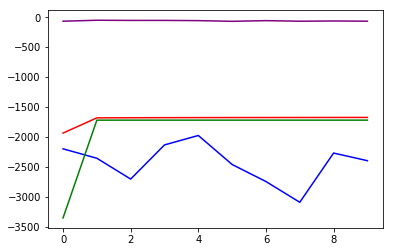

In [41]:
plt.plot( it[ :10 ], y1[ :10 ], color='red', label='em' )
plt.plot( it[ :10 ], y2[ :10 ], color='blue', label='gibbs' )
plt.plot( it[ :10 ], y3[ :10 ], color='green', label='elbo' )
plt.plot( it[ :10 ], y4[ :10 ], color='purple', label='svi' )
plt.show()

In [70]:
groups = [ 0, 1, 2 ]
d_latents = dict( zip( groups, [ 2, 3, 4 ] ) )
d_obs = 4

In [71]:
def graphToGroupGraph( graphs, dataPerNode, groupPerNode, with_fbs=False, random_latent_states=False, d_latents=None ):
    assert isinstance( graphs, list )
    group_graphs = []
    for graph in graphs:

        if( with_fbs ):
            if( not isinstance( graph, Graph ) ):
                graph, fbs = graph
            else:
                graph, fbs = graph, np.array( [] )

        data = [ ( node, dataPerNode( node ) ) for node in graph.nodes ]
        group = [ ( node, groupPerNode( node ) ) for node in graph.nodes ]
        group_graph = GroupGraph.fromGraph( graph, data, group )

        if( random_latent_states ):
            assert d_latents is not None
            for node in group_graph.nodes:
                group = group_graph.groups[ node ]
                possible_latent_states = np.array( list( set( np.random.choice( np.arange( d_latents[ group ] ), d_latents[ group ] - 1 ).tolist() ) ) )
                group_graph.setPossibleLatentStates( node, possible_latent_states )

        if( with_fbs ):
            group_graphs.append( ( group_graph, fbs ) )
        else:
            group_graphs.append( group_graph )
    return group_graphs

def dataPerNode( node ):
    return Categorical.generate( D=d_obs, size=1 )
def groupPerNode( node ):
    return Categorical.generate( D=len( groups ) )

group_graphs = graphToGroupGraph( graphs, dataPerNode, groupPerNode, with_fbs=True )

In [72]:
shapes = GroupGHMM.parameterShapes( group_graphs, d_latents={ 0:2, 1:3, 2:4 }, d_obs=4, groups=[ 0, 1, 2 ] )
initial_shapes, transition_shapes, emission_shapes = shapes

In [73]:
initial_priors = dict( ( group, np.ones( shape ) ) for group, shape in initial_shapes.items() )
transition_priors = dict( ( group, [ np.ones( shape ) for shape in shapes ] ) for group, shapes in transition_shapes.items() )
emission_prior = dict( ( group, np.ones( shape ) ) for group, shape in emission_shapes.items() )

In [74]:
true_model = GroupGHMM( priors=( initial_priors, transition_priors, emission_prior ), method='EM' )

In [75]:
for i, ( graph, fbs ) in enumerate( group_graphs ):
    true_model.setGraphs( [ ( graph, fbs ) ] )
    _, data = true_model.sampleStates()
    graph.setNodeData( data.keys(), data.values() )

In [76]:
em_model    = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
gibbs_model = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='Gibbs' )
cavi_model  = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='CAVI' )
svi_model   = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='SVI', step_size=0.1, minibatch_size=1 )

In [77]:
cavi_model.fitStep()

-726.6312738823931

In [78]:
cavi_model.fitStep()

-522.881220636551

# Test 2 - Wide graphs without cycles

# Test 3 - Deep graphs with cycles

# Test 4 - Wide graphs with cycles